# TP1 - Classification par Kppv

Dans ce TP, nous allons utiliser une partie de la base de visages ‚ÄúLabeled Faces in the Wild‚Äù provenant de http://vis-www.cs.umass.edu/lfw/. Cette base contient 5749 personnes et 13233 images de taille 62 x 47 pixels. Certaines personnes ne sont repr√©sent√©es qu‚Äôune seule fois tandis que d‚Äôautres sont repr√©sent√©es tr√®s souvent (plus de 80 fois). Nous utiliserons ici seulement 7 personnes repr√©sent√©es 1288 fois.

In [4]:
# Importer les librairies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from time import perf_counter 

## I- Chargement des donn√©es:

### Charger les donn√©es
Charger les donner, puis afficher les en utilisant la fonction plot_gallery()  fournie.

In [5]:
def plot_gallery(images):
# Affiche les 12 premi√®res images contenues dans images
# images est de taille Nb imageNyNx
    plt.figure(figsize=(7.2, 7.2))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.show()


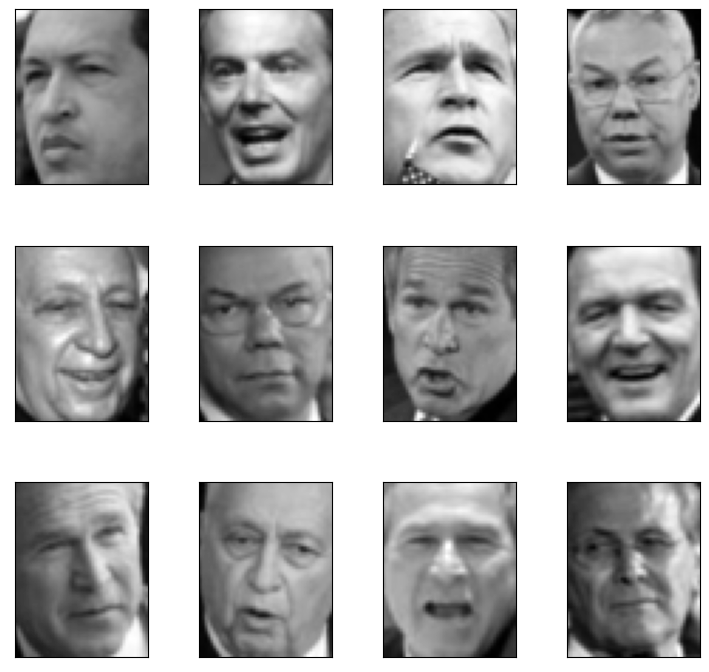

In [6]:
[X, y, name]=np.load("TP1.npy",allow_pickle=True )
plot_gallery(X)

#### Question

- Sachant que X repr√©sente les features, y les labels et name le nom des classes, d√©terminer la taille des images, le nombre d‚Äôimages et le nombre de classes.

- Retrouver l‚Äôidentit√© des 12 personnes affich√©es. Est-ce que les classes sont √©quiprobables ? 

- Retrouver le nombre d‚Äôexemples par classe. On pourra pour cela utiliser l‚Äôhistogramme (plt.hist()).

**1. d√©terminons la taille des images, le nombre d‚Äôimages et le nombre de classes.**

In [18]:
X.shape

(1288, 62, 47)

In [8]:
y.shape

(1288,)

In [9]:
name.shape

(7,)

In [14]:
print(f"taille des images: {X.ndim * y.ndim}")

taille des images: 3


In [15]:
print(f"nombre d'images : {len(np.unique(X))}")

nombre d'images : 766


In [17]:
print(f"nombre de classes : {len(np.unique(name))}")

nombre de classes : 7


1.b **Retrouvons l‚Äôidentit√© des 12 personnes affich√©es. Est-ce que les classes sont √©quiprobables ?** 

In [38]:
X.shape[0]

1288

In [22]:
print(y[:12])

[5 6 3 1 0 1 3 4 3 0 3 2]


In [23]:
print(name[:12])

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [25]:
# l‚Äôidentit√© des 12 personnes affich√©es
for i in y[:12]:
    print(name[i])

Hugo Chavez
Tony Blair
George W Bush
Colin Powell
Ariel Sharon
Colin Powell
George W Bush
Gerhard Schroeder
George W Bush
Ariel Sharon
George W Bush
Donald Rumsfeld


In [35]:
# Est-ce que les classes sont √©quiprobables ?
ens = set()
for i,j in enumerate(y):
    ens |= {(name[j], np.count_nonzero(y == j))}
ens
    

{('Ariel Sharon', 77),
 ('Colin Powell', 236),
 ('Donald Rumsfeld', 121),
 ('George W Bush', 530),
 ('Gerhard Schroeder', 109),
 ('Hugo Chavez', 71),
 ('Tony Blair', 144)}

In [41]:
# Count Occurrences of Each Unique Value
ens2 = set()
for i,j in enumerate(y):
    ens2 |= {(name[j], (np.count_nonzero(y == j))/X.shape[0])}
ens2

{('Ariel Sharon', 0.059782608695652176),
 ('Colin Powell', 0.18322981366459629),
 ('Donald Rumsfeld', 0.09394409937888198),
 ('George W Bush', 0.4114906832298137),
 ('Gerhard Schroeder', 0.08462732919254658),
 ('Hugo Chavez', 0.05512422360248447),
 ('Tony Blair', 0.11180124223602485)}

In [73]:
import pandas as pd
mydf = pd.DataFrame(ens2)

In [74]:
mydf.columns = ['name','probability']
mydf

name  probability
0        Hugo Chavez     0.055124
1       Colin Powell     0.183230
2  Gerhard Schroeder     0.084627
3       Ariel Sharon     0.059783
4      George W Bush     0.411491
5         Tony Blair     0.111801
6    Donald Rumsfeld     0.093944

In [55]:
import matplotlib
%matplotlib inline

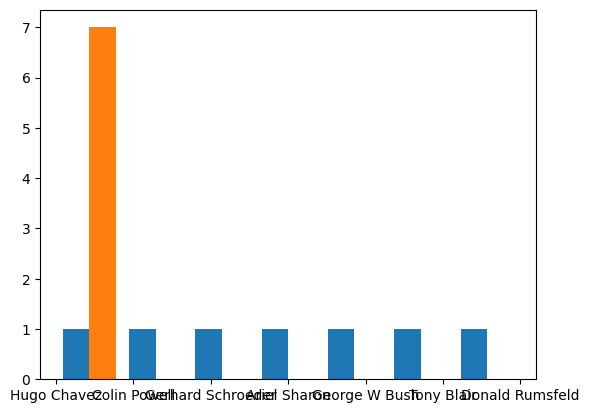

In [82]:
plt.hist(mydf, bins=7)
plt.show()

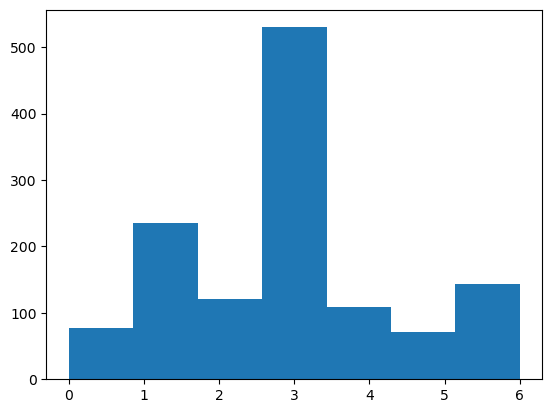

In [79]:
plt.hist(y,bins=7)
plt.show()

### Partitionnement de la base d‚Äôapprentissage

Partitionner la base en une base d‚Äôapprentissage et une base de test en mettant 25% des donn√©es
en test (fonction train_test_split()) pour obtenir les variables X_train, X_test, y_train et y_test.

In [76]:
from sklearn.preprocessing import LabelEncoder

In [77]:
X_encoder, Y_encoder = LabelEncoder(), LabelEncoder()

In [85]:
X = X_encoder.fit_transform(X)
y = Y_encoder.fit_transform(y.values().ravel())

ValueError: y should be a 1d array, got an array of shape (1288, 62, 47) instead.

#### Question
- Combien y a-t-il d‚Äôimages en train et en test ? 
- Quelles sont les dimensions des quatre variables X_train, X_test, y_train et y_test ?

## II. Pr√©traitement des donn√©es:

### Redimensionnement des donn√©es

Pour r√©aliser une classification par kppv, on utilise un codage r√©tinien. Chaque image est donc repr√©sent√©e par un vecteur de caract√©ristique de dimension ùëõ = 2914. Redimensionner X_train et X_test de fa√ßon √† ce qu‚Äôils aient pour dimension ùëÅ x ùëõ (np.reshape()) o√π N est le nombre d‚Äôexemples.

### Mise en forme des donn√©es pour la classification

Mettre en forme les donn√©es (train et test) en utilisant la classe StandardScaler. On estimera la moyenne et l‚Äô√©cart-type de chaque dimension sur les donn√©es d‚Äôapprentissage, puis on transformera les donn√©es (train et test) en utilisant ces valeurs. Aller sur la documentation en
ligne de StandardScaler pour voir quelle m√©thode de cette classe utiliser.

#### Question
- A quoi consiste la mise en forme des donn√©es ? 

- Comment sont-elles transform√©es ?

## III. Classification par les KPPV:

### Classifieur 1PPV

- D√©finir le classifieur 1PPV en utilisant la classe KNeighborsClassifier(). On souhaite utiliser la distance euclidienne et le 1PPV. 

- Train le classifieur sur X_train, y_train.

- R√©aliser la classification des exemples de test en utilisant la m√©thode predict().

#### Questions 
- Que repr√©sente la matrice de confusion ?
- Que vaut sa somme ? 
- Est-ce que les classes sont √©quilibr√©es ?



Afficher la matrice de confusion (fonction confusion_matrix()) et estimer le taux dereconnaissance √† partir des √©l√©ments de cette matrice. V√©rifier que le taux est identique √† celui renvoy√© par la fonction accuracy_score().

### Classifieur KPPV
Faire varier le K des KPPV et tracer l‚Äô√©volution du taux de reconnaissance en fonction de K.

#### Questions :

Conclusion ? Interpr√©ter l‚Äô√©volution des r√©sultats en fonction de K

### Classifieur KPPV et distance de Manhattan

R√©aliser les m√™mes tests avec la distance de Manhattan.

#### Questions :
- Conclusion ? Interpr√©ter l‚Äô√©volution des r√©sultats en fonction de K.
- Pour r√©soudre ce probl√®me de classification, quelle distance et valeur de K choisissez-vous suite √† ces tests ?

# TP2: Analyse en composantes principales, classification et reconstruction :



## I. Chargement et mise en forme des donn√©es:

On utilisera les m√™mes donn√©es que lors du TP1 avec leur redimensionnement et leur mise en forme.

#### Questions

- Combien y a-t-il de donn√©es en apprentissage et en test ?
- Quelle est la dimension des donn√©es apr√®s redimensionnement ?


## II. Analyse en composantes principales et classification

1. D√©finissez la d√©composition en composantes principales en utilisant la fonction PCA() en gardant le maximum de composantes, ajuster le mod√®le sur X_train (   ) puis tracer les variances en utilisant l‚Äôattribut pca.explained_variance_ratio_  


2. Red√©finissez la d√©composition en utilisant la fonction   en conservant 100 composantes, ajuster le mod√®le sur X_train, puis transformez les donn√©es X_train et X_test pour obtenir X_train1 et X_test1.

3. R√©aliser la classification sur les donn√©es de d√©part puis sur les nouvelles donn√©es avec la m√©thode du 5PPV et la distance de Manhattan. Conclure sur le taux de reconnaissance et les temps de calcul qui peuvente √™tre d√©termin√©s par :



```
from time import perf_counter
 tps1 = perf_counter()
 tps2 = perf_counter()
 print("Dur√©e de classification",tps2 - tps1)
```



#### Questions :

- Que repr√©sentent les valeurs renvoy√©es par pca.explained_variance_ratio_ ? 

- Observer la taille de X_train1 et X_test1. Quelle est la nouvelle dimension des donn√©es ?
- Comment varient les temps de calcul entre une classification avec ou sans ACP ?
- Comment varient les taux de reconnaissance ?

## III. Analyse en composantes principales et reconstruction

Le but est de compresser les images afin qu‚Äôelle prenne moins de place en m√©moire. On va donc d√©finir sur X_train la fa√ßon de compresser. Puis on comprimera et d√©comprimera les images de X_test afin de voir les pertes induites par la compression.

- D√©finissez la d√©composition en composantes principales en utilisant la fonction PCA() en conservant 50 composantes et ajuster le mod√®le sur X_train.


- R√©cup√©rer les vecteurs propres en utilisant un attribut de PCA(). 

- Redimensionner les vecteurs propres en images propres (np.reshape()) de mani√®re √† pourvoir les visualiser sous forme d‚Äôimages (array de taille 50x62x47). On utilisera la fonction plot_gallery() pour la visualisation.

Questions:

- Que repr√©sentent les vecteurs propres ?
- Quelle est leur taille ?

Les vecteurs propres repr√©sentent: 

Les axes principaux dans l'espace d'entit√©s, repr√©sentant les directions de variance maximale dans les donn√©es. Les composants sont tri√©s par explication_variance_.

- On souhaite comprimer les images de X_test afin de les transmettre en utilisant le moins de bande passante possible. Pour cela, les 50 images propres sont transmises une fois. Pour chaque nouvelle image, on transmet uniquement ses composantes dans le nouveau syst√®me d‚Äôaxe de dimension 50. L‚Äôimage est ensuite reconstruite √† l‚Äôarriv√©e.
Appliquer l‚ÄôACP des images de X_test (X_testC)

- Reconstruisez les images √† partir X_testC pour obtenir les images X_testR √† partir d‚Äôune
des m√©thodes de PCA(). Afficher les images reconstruites et les comparer visuellement
aux images de d√©part.

-  Comparer les images initiales et reconstruites de mani√®re quantitative en faisant la
moyenne des distances euclidiennes :


```
E= (X_testR-X_test)**2
E = np.mean(np.sqrt(np.sum(E,axis=0)))
```

Questions: 

- Comparer les tailles de X_test et X_testC et en d√©duire le taux de compression.
- Observer la taille de X_testR. Quel est le principe de la reconstruction des images ?

- Comment passe-t-on de X_testC √† X_testR ?

- Faire varier le nombre de composantes conserv√©es de 10 √† 950 par pas de 50 et calculer l‚Äôerreur de reconstruction. Afficher l‚Äôerreur de reconstruction en fonction du nombre de composantes.

- Comment varie l‚Äôerreur de reconstruction en fonction du nombre de composantes ? 
- Comparer visuellement les images initiales et reconstruites √† partir de 950
composantes. Conclusion ?